In [43]:
%matplotlib inline

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, AveragePooling2D, Dense, Dropout, Flatten)
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

sns.set_style('whitegrid')
results_path = Path('results')
mnist_path = results_path / 'mnist'
if not mnist_path.exists():
    mnist_path.mkdir(parents=True)

Using GPU


In [45]:
# load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f'The MNIST database has a training set of {len(X_train)} examples with {X_train.shape} shape')
print(f'The MNIST database has a test set of {len(X_test)} examples with {X_test.shape} shape')

The MNIST database has a training set of 60000 examples with (60000, 28, 28) shape
The MNIST database has a test set of 10000 examples with (10000, 28, 28) shape


before flatten():(2, 5)
after  flatten():(10,)


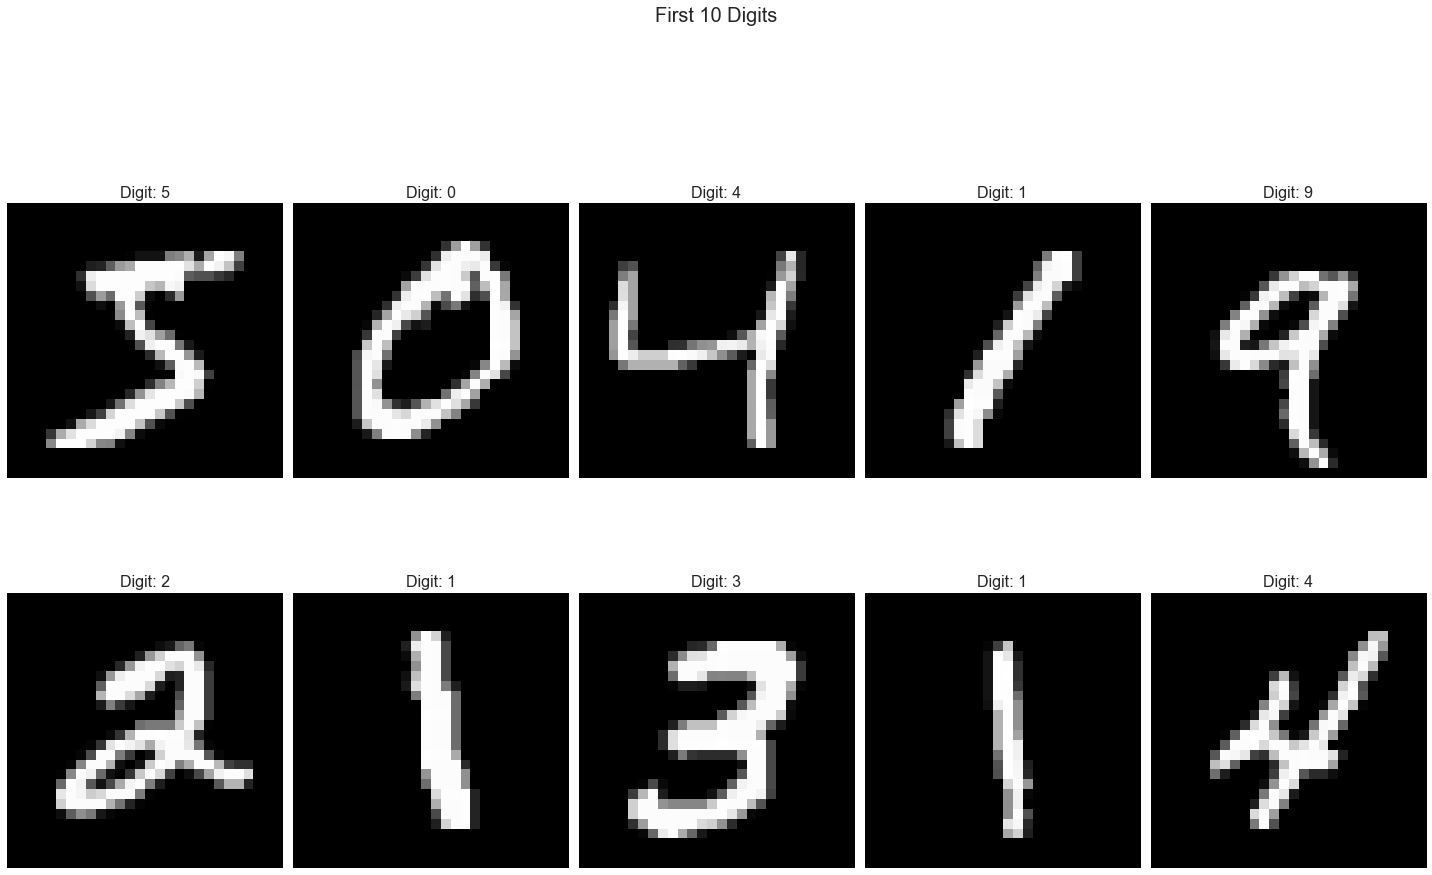

In [46]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 14))

print(f'before flatten():{axes.shape}')
# flatten() ravel() difference: copy function(flatten() change the value, where ravel() not change)
axes = axes.flatten() # reshape from multi-dimension to 1-dimension
print(f'after  flatten():{axes.shape}')

for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')
    ax.set_title('Digit: {}'.format(y_train[i]), fontsize=16)

fig.suptitle('First 10 Digits', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)

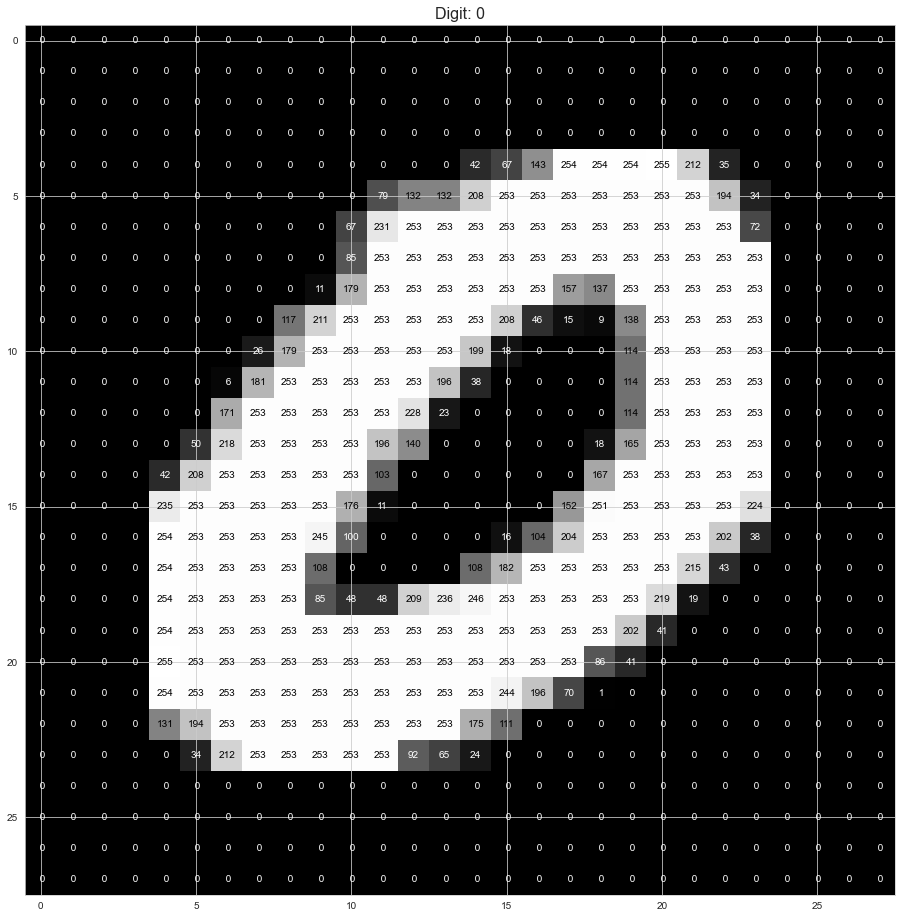

In [47]:
# Show random image in detail
fig, ax = plt.subplots(figsize = (16, 16))

i = randint(0, len(X_train))
img = X_train[i]

ax.imshow(img, cmap='gray')
ax.set_title('Digit: {}'.format(y_train[i]), fontsize=16)

width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        ax.annotate(f'{img[x][y]:2}', xy=(y,x), horizontalalignment='center',
                    verticalalignment='center', color='white' if img[x][y]<thresh else 'black')

In [48]:
# Prepare Data
X_train = X_train.astype('float32')/255  # rescale from [0,255] to [0,1] and to float32 for memory efficiency
X_test = X_test.astype('float32')/255

# One-Hot Label Encoding
print('Integer-valued labels:')
print(y_train[:10])

# Feed-Forward NN
ffnn = Sequential([Flatten(input_shape=X_train.shape[1:]), # 28 * 28 = 784
    Dense(512, activation='relu'), # (784 + 1) * 512 = 401920
    Dropout(0.2),
    Dense(512, activation='relu'), # (512 + 1) * 512 = 262656
    Dropout(0.2),
    Dense(10, activation='softmax') # (512 + 1) * 10 = 5130
])
ffnn.summary()

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total par

In [49]:
ffnn.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# evaluate test accuracy
baseline_accuracy = ffnn.evaluate(X_test, y_test, verbose=0)[1]

# print test accuracy
print(f'Test accuracy: {baseline_accuracy:.2%}')

Test accuracy: 10.04%


In [50]:
# Callback for model persistence
ffn_path = mnist_path / 'ffn.best.hdf5'
checkpointer = ModelCheckpoint(filepath=ffn_path.as_posix(), verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

epochs = 100
batch_size = 32
ffnn_history = ffnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,
                        callbacks=[checkpointer, early_stopping], verbose=1, shuffle=True, workers=6)

Epoch 1/100
1495/1500 [============================>.] - ETA: 0s - loss: 0.2387 - accuracy: 0.9292
Epoch 00001: val_loss improved from inf to 0.12191, saving model to results/mnist\ffn.best.hdf5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2383 - accuracy: 0.9294 - val_loss: 0.1219 - val_accuracy: 0.9651
Epoch 2/100
1488/1500 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.9653
Epoch 00002: val_loss did not improve from 0.12191
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1308 - accuracy: 0.9655 - val_loss: 0.1427 - val_accuracy: 0.9680
Epoch 3/100
1493/1500 [============================>.] - ETA: 0s - loss: 0.1158 - accuracy: 0.9718
Epoch 00003: val_loss improved from 0.12191 to 0.10907, saving model to results/mnist\ffn.best.hdf5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1156 - accuracy: 0.9719 - val_loss: 0.1091 - val_accuracy: 0.9748
Epoch 4/100
1479/1500 [============================>.] - 

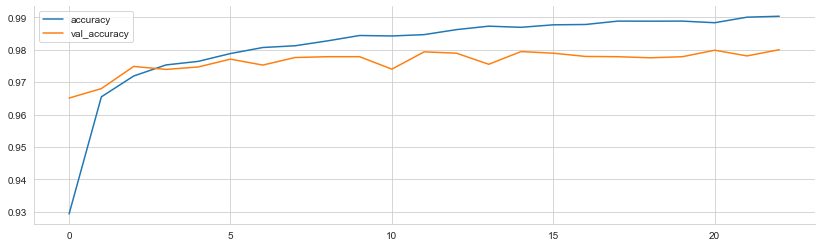

In [51]:
# Plot CV Results
pd.DataFrame(ffnn_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14,4))
sns.despine();

In [52]:
# Load the Best Model
ffnn.load_weights(ffn_path.as_posix()) # load the weights that yielded the best validation accuracy
ffnn_accuracy = ffnn.evaluate(X_test, y_test, verbose=0)[1] # evaluate test accuracy

print(f'Test accuracy: {ffnn_accuracy:.2%}')

Test accuracy: 97.81%


In [53]:
# LeNet5 - designed for checks handwriting recognition and used by several banks
K.clear_session() # Resets all state

lenet5 = Sequential([
    # Conv2D
    #   filters(# of output channels after Conv)
    #   kernel_size(size of a Conv filter being used for Conv)
    Conv2D(filters=6, kernel_size=5, activation='relu', input_shape=(28, 28, 1), name='CONV1'),
    AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid', name='POOL1'),
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', name='CONV2'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL2'),
    Conv2D(filters=120, kernel_size=(5, 5), activation='tanh', name='CONV3'),
    Flatten(name='FLAT'),
    Dense(units=84, activation='tanh', name='FC6'),
    Dense(units=10, activation='softmax', name='FC7')
])

lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 24, 24, 6)         156       
                                                                 
 POOL1 (AveragePooling2D)    (None, 23, 23, 6)         0         
                                                                 
 CONV2 (Conv2D)              (None, 19, 19, 16)        2416      
                                                                 
 POOL2 (AveragePooling2D)    (None, 9, 9, 16)          0         
                                                                 
 CONV3 (Conv2D)              (None, 5, 5, 120)         48120     
                                                                 
 FLAT (Flatten)              (None, 3000)              0         
                                                                 
 FC6 (Dense)                 (None, 84)                2

In [54]:
lenet5.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Define checkpoint callback
lenet_path = mnist_path / 'lenet.best.hdf5'
checkpointer = ModelCheckpoint(filepath=lenet_path.as_posix(), verbose=1, save_best_only=True)

In [55]:
batch_size=32
epochs=100
lenet_history = lenet5.fit(X_train.reshape(-1, 28, 28, 1), y_train, batch_size=batch_size, epochs=epochs,
    validation_split=0.2,  # use 0 to train on all data
    callbacks=[checkpointer, early_stopping], verbose=1, shuffle=True, workers=6)

Epoch 1/100
1494/1500 [============================>.] - ETA: 0s - loss: 0.4921 - accuracy: 0.8643
Epoch 00001: val_loss improved from inf to 0.23876, saving model to results/mnist\lenet.best.hdf5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4911 - accuracy: 0.8646 - val_loss: 0.2388 - val_accuracy: 0.9355
Epoch 2/100
1486/1500 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9425
Epoch 00002: val_loss improved from 0.23876 to 0.15862, saving model to results/mnist\lenet.best.hdf5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2022 - accuracy: 0.9427 - val_loss: 0.1586 - val_accuracy: 0.9567
Epoch 3/100
1493/1500 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9590
Epoch 00003: val_loss improved from 0.15862 to 0.12135, saving model to results/mnist\lenet.best.hdf5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1440 - accuracy: 0.9591 - val_loss: 0.1214 - val_accuracy: 0.9668
Ep

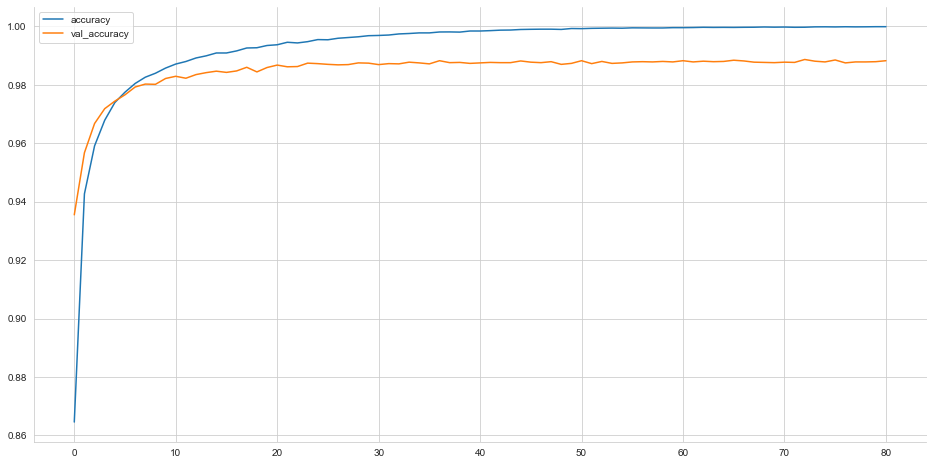

In [56]:
# Plot CV Results
pd.DataFrame(lenet_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(16,8))
sns.despine();

In [57]:
# evaluate test accuracy
lenet_accuracy = lenet5.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(lenet_accuracy))

Test accuracy: 98.99%
